In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("/home/tesserxt/AllProjects/jupyter/campusx/content/house_price/train.csv")
df, test_df = train_test_split(df, random_state=23, test_size=0.2)

In [3]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,947.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1160.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1106.000000,1168.000000,1168.00000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,726.796233,56.772260,69.956705,10631.202055,6.111301,5.567637,1971.372432,1984.402397,107.298276,449.464897,43.559932,568.495719,1061.520548,1163.691781,361.025685,5.601027,1530.318493,0.423801,0.054795,1.571062,0.399829,2.889555,1.047945,6.567637,0.617295,1978.397830,1.765411,472.15411,97.164384,48.607021,21.808219,3.558219,15.232021,3.448630,51.219178,6.355308,2007.806507,182133.373288
std,422.071063,41.800536,23.602487,10728.641961,1.380961,1.116464,29.851977,20.636339,184.085879,461.570742,152.984499,441.676763,454.200801,399.621557,444.056341,47.037407,540.648831,0.523008,0.231409,0.557032,0.507257,0.825241,0.225448,1.651946,0.650575,24.442951,0.746154,213.04148,128.268946,68.246156,61.304968,30.888916,57.385392,44.896939,552.958608,2.724032,1.333206,81371.459472
min,1.000000,20.000000,21.000000,1300.000000,1.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1908.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,362.750000,20.000000,59.000000,7538.750000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,229.750000,793.000000,876.000000,0.000000,0.000000,1139.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,324.25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,720.500000,50.000000,70.000000,9433.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,386.500000,0.000000,474.000000,992.000000,1080.000000,0.000000,0.000000,1471.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,478.00000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163950.000000
75%,1086.250000,70.000000,80.000000,11665.500000,7.000000,6.000000,2000.000000,2003.000000,171.000000,720.250000,0.000000,803.250000,1306.750000,1391.000000,739.000000,0.000000,1796.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.00000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1127.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.00000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [264]:
# df.select_dtypes(include='number')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 1290 to 595
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    947 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          68 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallCond

In [265]:
df[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']] = df[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].astype('object')

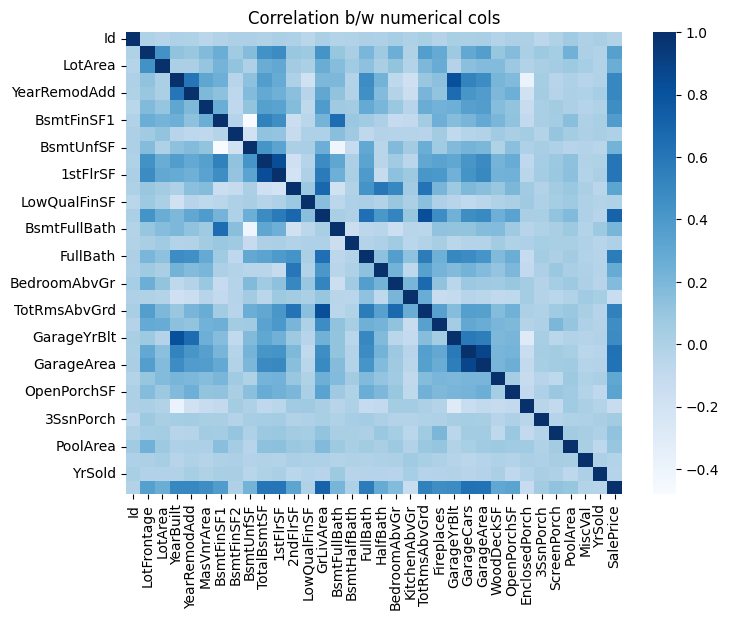

In [266]:

hn =  df.select_dtypes(include='number').corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(hn, cmap='Blues', ax=ax)
plt.title('Correlation b/w numerical cols')
plt.show()

In [267]:
cors = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).to_frame()

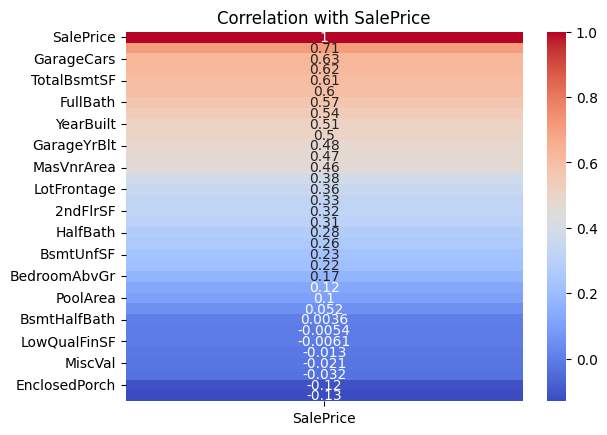

In [268]:
# Plot heatmap
sns.heatmap(cors, annot=True, cmap='coolwarm')
plt.title('Correlation with SalePrice')
plt.show()

In [269]:
imp_num_cols = cors.query("SalePrice > 0.6") #columns(features) highly correlated to SalePrice
imp_num_cols.iloc[1:-1]

,SalePrice
GrLivArea,0.709224
GarageCars,0.628199
GarageArea,0.620538
TotalBsmtSF,0.605786


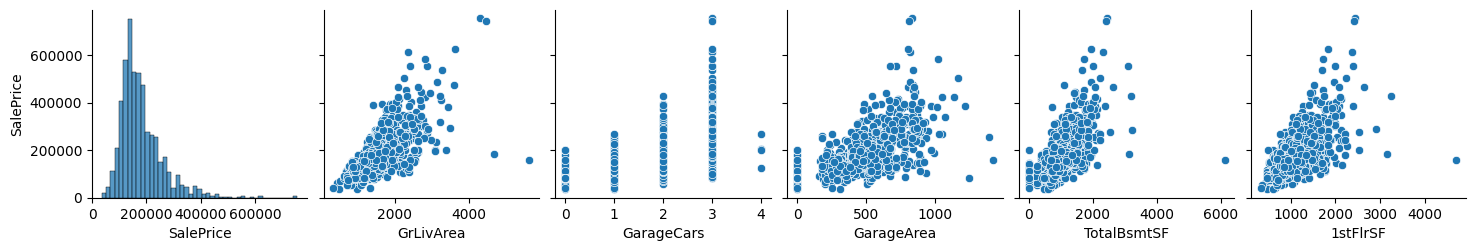

In [270]:
#fig, ax = plt.subplots(figsize=(18,10))
g = sns.pairplot(df, y_vars='SalePrice', x_vars=imp_num_cols.index, kind='scatter')


<Axes: xlabel='SalePrice', ylabel='Count'>

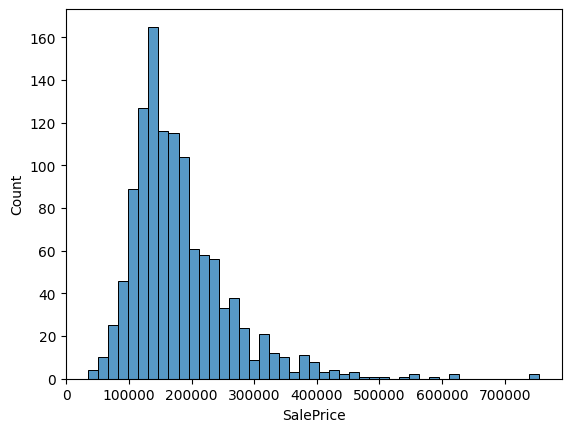

In [271]:
sns.histplot(df['SalePrice'])

In [272]:
set(df.dtypes.tolist())

{dtype('int64'), dtype('float64'), dtype('O')}

In [273]:
df_cat = df.select_dtypes(include=['object', 'category'])
cat_cols = df_cat.columns.tolist()

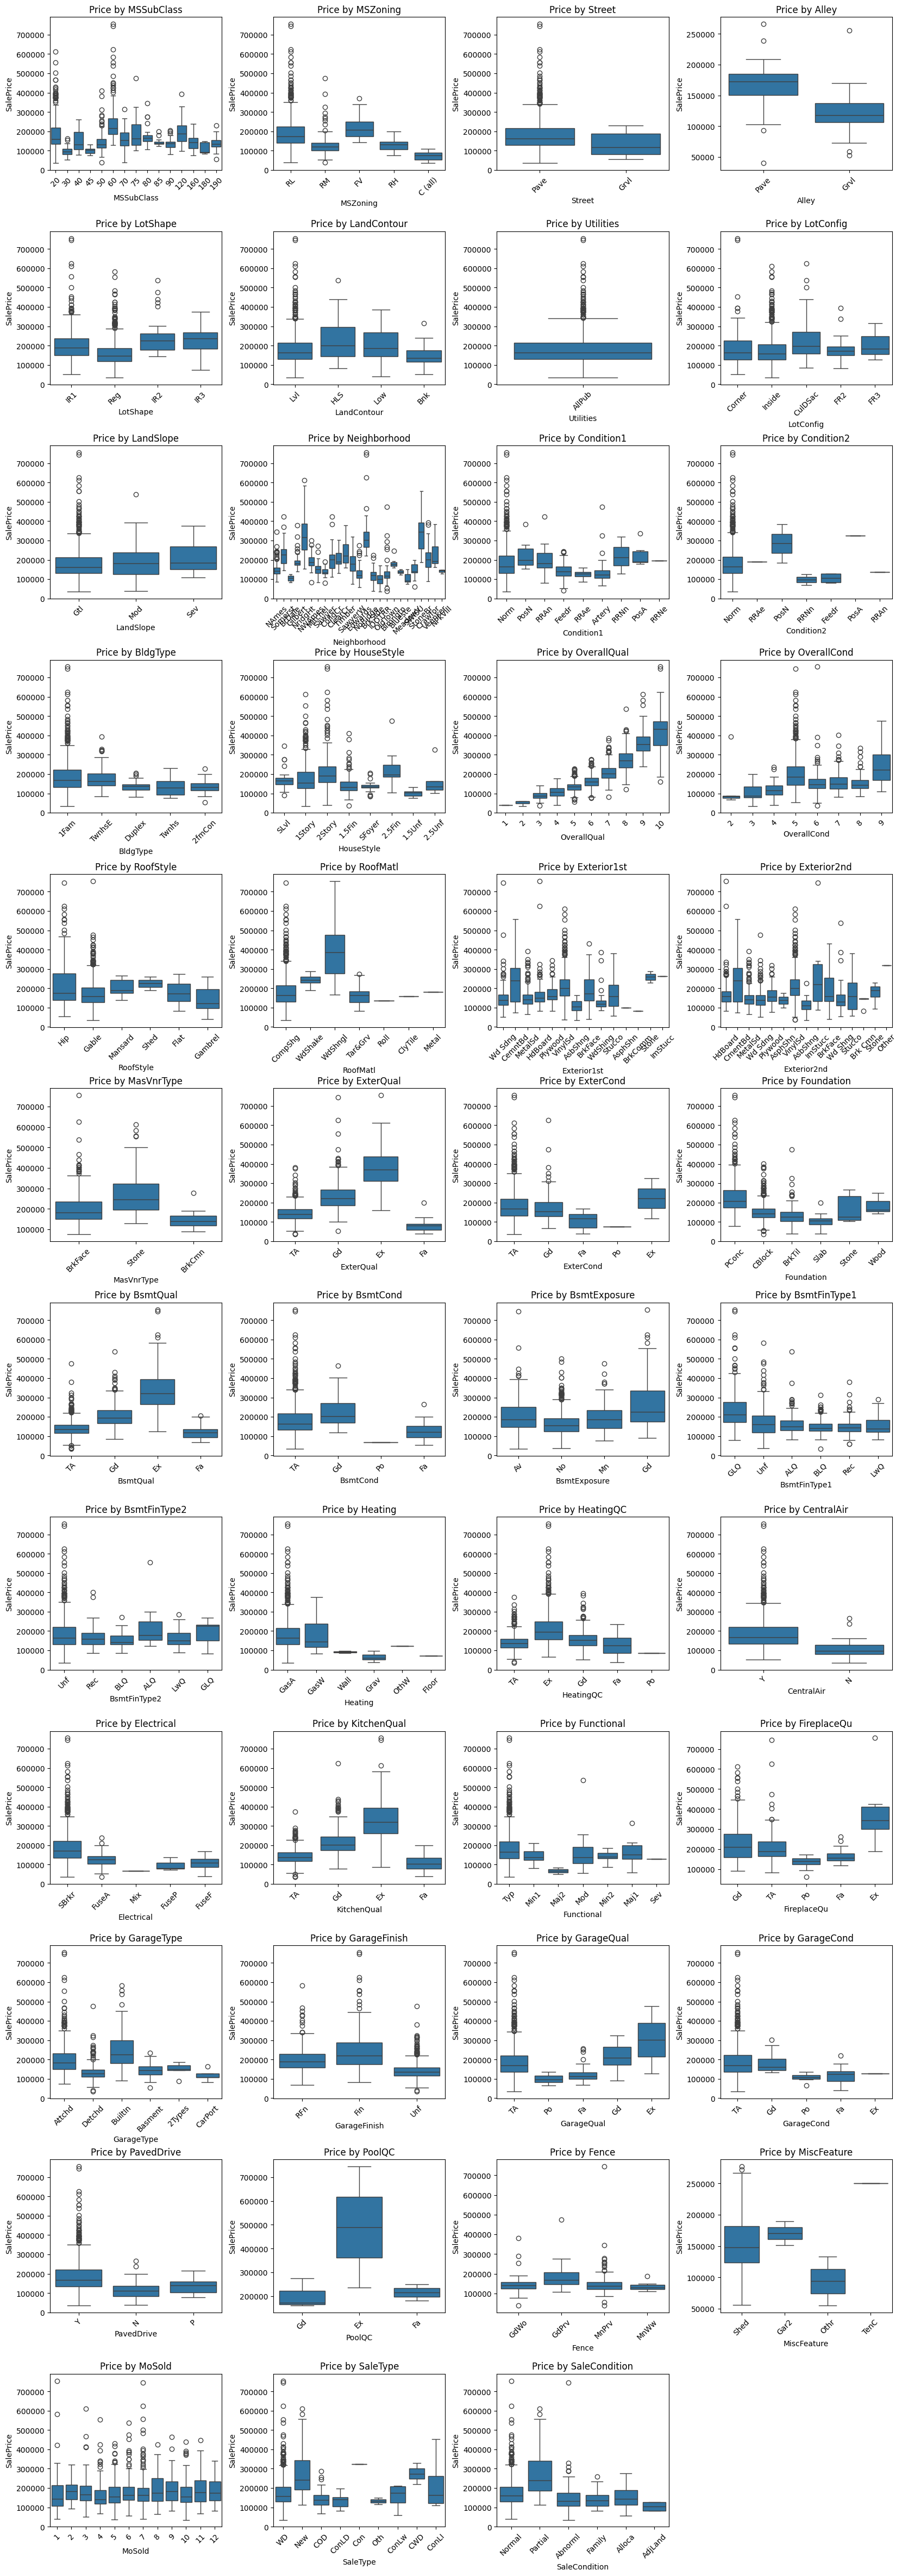

In [274]:
n_cols = 4
n_rows = (len(cat_cols) // n_cols + 1)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(cat_cols):
    ax = axes[i // n_cols, i % n_cols] if len(cat_cols) > n_cols else axes[i]
    sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)
    ax.set_title(f'Price by {col}')
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])
    

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

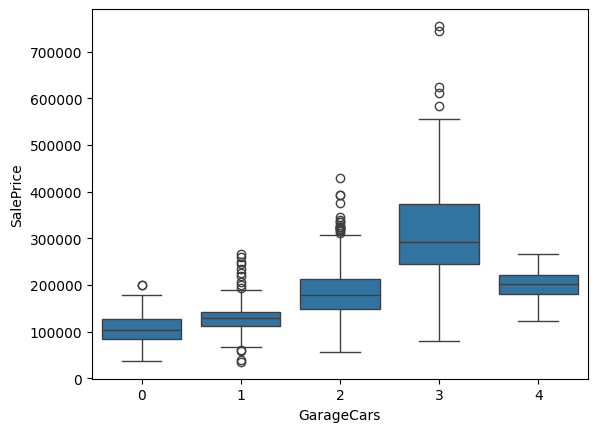

In [275]:
sns.boxplot(x=df.GarageCars, y=df.SalePrice)

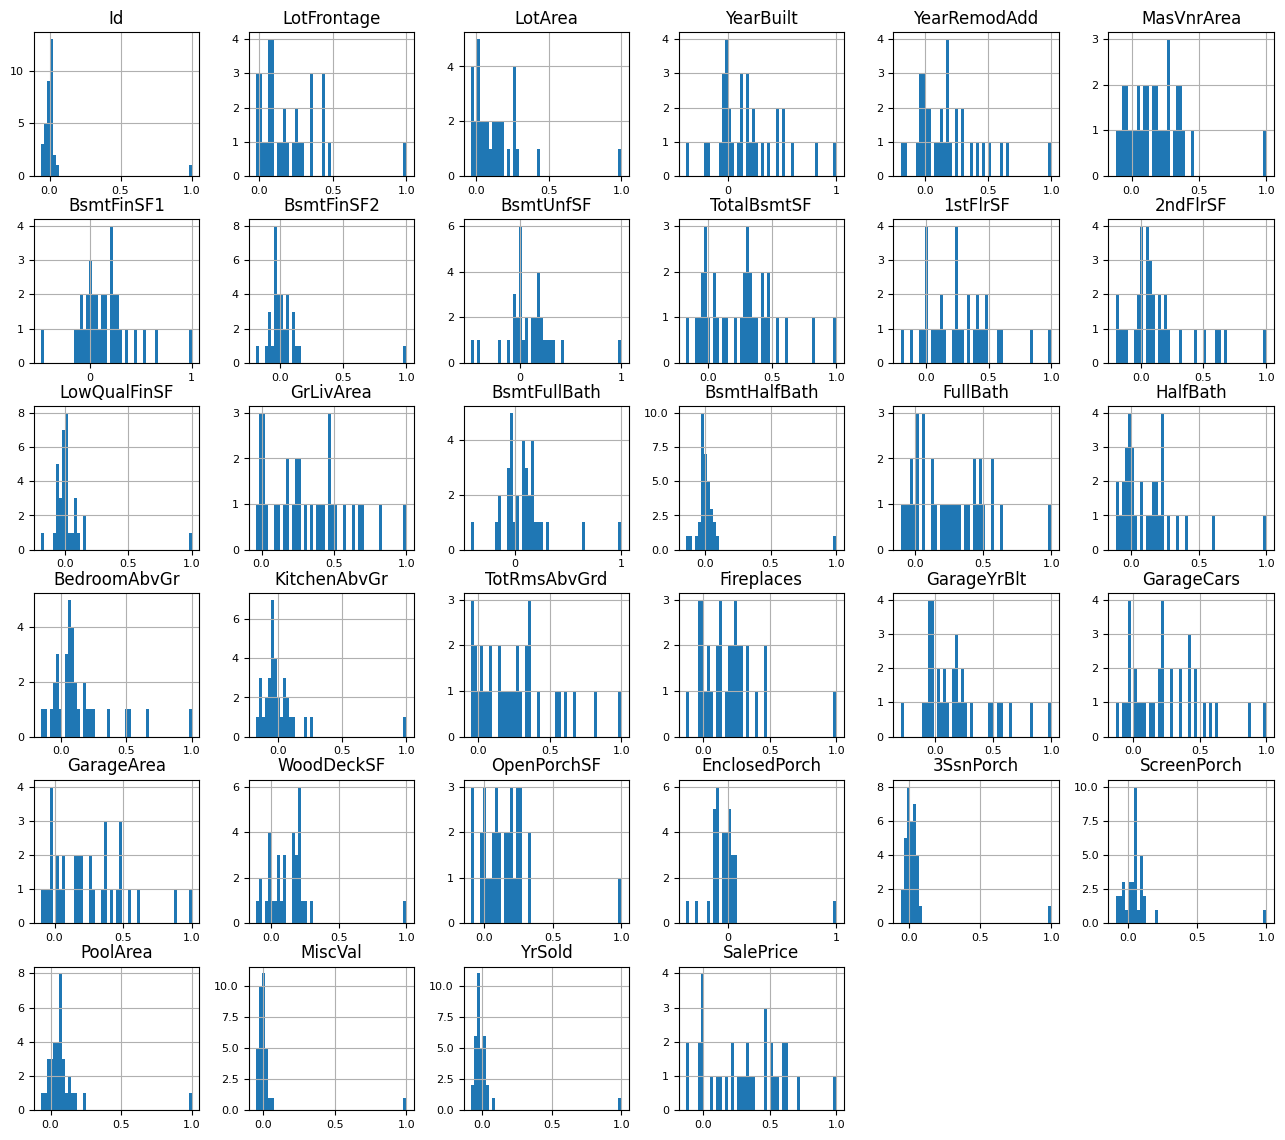

In [276]:
hn.hist(figsize=(16, 14), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [277]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1290,1291,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,SLvl,5,7,1964,1964,Hip,CompShg,Wd Sdng,HdBoard,BrkFace,86.0,TA,TA,PConc,TA,TA,Av,GLQ,1014,Unf,0,138,1152,GasA,TA,Y,SBrkr,1152,0,0,1152,1,0,1,0,3,1,TA,6,Typ,1,Gd,Attchd,1964.0,RFn,2,484,TA,TA,Y,227,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500
793,794,20,RL,76.0,9158,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,CemntBd,CmentBd,Stone,140.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1496,1496,GasA,Ex,Y,SBrkr,1496,0,0,1496,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2007.0,Fin,2,474,TA,TA,Y,168,130,0,0,0,0,NaN,NaN,NaN,0,6,2007,New,Partial,225000
83,84,20,RL,80.0,8892,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1960,Gable,CompShg,MetalSd,MetalSd,BrkCmn,66.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1065,1065,GasA,Gd,Y,SBrkr,1065,0,0,1065,0,0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1974.0,Unf,2,461,TA,TA,Y,74,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,COD,Normal,126500
432,433,160,RM,24.0,1920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,5,5,1971,1971,Gable,CompShg,HdBoard,HdBoard,BrkFace,376.0,TA,TA,CBlock,TA,TA,No,ALQ,471,Unf,0,294,765,GasA,Ex,Y,SBrkr,765,600,0,1365,1,0,1,1,2,1,TA,6,Min1,0,NaN,Detchd,1971.0,Unf,2,440,TA,TA,Y,240,36,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,122500
929,930,60,RL,NaN,13006,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1997,1997,Gable,CompShg,HdBoard,HdBoard,BrkFace,285.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,964,964,GasA,Gd,Y,SBrkr,993,1243,0,2236,0,0,2,1,4,1,Gd,8,Typ,1,TA,BuiltIn,1997.0,Fin,2,642,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,222000


In [278]:
x = df[imp_num_cols.drop('SalePrice').index]
y = df.iloc[:, -1]

In [279]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X=x, y=y)

LinearRegression()

In [ ]:
# test_df = pd.read_csv("/home/tesserxt/AllProjects/jupyter/campusx/content/house_price/test.csv")
# imp_test_df = test_df[imp_num_cols.drop('SalePrice').index]
# imp_test_df[imp_test_df.isna().any(axis=1)]
# imp_test_df.fillna(imp_test_df.mean(), inplace=True)




In [ ]:
# y_pred = lr.predict(imp_test_df)
from sklearn.metrics import r2_score

# r2_score(y_pred=y_pred, y_true=test_df.SalePrice)

In [ ]:
test_file_path = "/home/tesserxt/AllProjects/jupyter/campusx/content/house_price/test.csv"
test_df = pd.read_csv(test_file_path)
test_data = test_df[imp_num_cols.drop("SalePrice").index]
test_data.fillna(test_data.mean(), inplace=True)
test_data.isnull().sum().sort_values(ascending=False)
ids = test_df.pop('Id')
preds = lr.predict(test_data)
	
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.to_csv('submission.csv', index=False)

/tmp/ipykernel_2216/252249898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(test_data.mean(), inplace=True)


# Insurance dataset

In [73]:
df = pd.read_csv("/home/tesserxt/AllProjects/jupyter/campusx/content/insurance_data.csv")
# df['gender'] = df['gender'].map({'male': 1, 'female': 0}).astype('UInt8')
# df['diabetic'] = df['diabetic'].map({'Yes': 1, 'No': 0}).astype('UInt8')
# df['smoker'] = df['smoker'].map({'Yes': 0, 'No': 1}).astype('UInt8')

# region_map = {'southeast': 0, 'northeast': 1, 'northwest': 2, 'southwest': 3}
# df['region'] = df['region'].map(region_map).astype('UInt8')
# df.insert(len(df.columns) - 1, 'bmi_category', df['bmi'].apply(categorize_bmi))
# df.dropna(inplace=True, ignore_index=True)

In [74]:
df

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01
...,...,...,...,...,...,...,...,...,...,...,...
1335,1335,1336,44.0,female,35.5,88,Yes,0,Yes,northwest,55135.40
1336,1336,1337,59.0,female,38.1,120,No,1,Yes,northeast,58571.07
1337,1337,1338,30.0,male,34.5,91,Yes,3,Yes,northwest,60021.40
1338,1338,1339,37.0,male,30.4,106,No,0,Yes,southeast,62592.87


In [75]:
X = df.iloc[:,[2,3,5,6,7,8,9,10]]
y = df.iloc[:, -1]
X

,age,gender,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,91,Yes,0,No,southeast,1121.87
1,24.0,male,87,No,0,No,southeast,1131.51
2,NaN,male,82,Yes,0,No,southeast,1135.94
3,NaN,male,80,No,0,No,northwest,1136.40
4,NaN,male,100,No,0,No,northwest,1137.01
...,...,...,...,...,...,...,...,...
1335,44.0,female,88,Yes,0,Yes,northwest,55135.40
1336,59.0,female,120,No,1,Yes,northeast,58571.07
1337,30.0,male,91,Yes,3,Yes,northwest,60021.40
1338,37.0,male,106,No,0,Yes,southeast,62592.87


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1072, 8) (268, 8) (1072,) (268,)


,age,gender,bloodpressure,diabetic,children,smoker,region,claim
1148,32.0,male,115,Yes,1,Yes,northwest,26109.33
807,51.0,female,83,Yes,0,No,northwest,11454.02
1287,32.0,female,96,Yes,0,Yes,northwest,42983.46
590,38.0,female,96,Yes,3,No,northeast,8252.28
1188,37.0,male,88,No,3,Yes,northwest,32787.46
...,...,...,...,...,...,...,...,...
1095,38.0,female,104,Yes,1,Yes,northeast,21771.34
1130,39.0,female,104,Yes,1,Yes,southwest,24520.26
1294,36.0,female,130,No,1,Yes,northwest,43943.88
860,37.0,female,84,Yes,0,No,northwest,12231.61


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pd.Series(lr.coef_, index = X.columns)

age                 35.220700
gender             -20.865559
bloodpressure      224.277036
diabetic          -379.638849
children           672.450139
smoker          -20778.697834
region             -56.370601
bmi_category      2095.337371
dtype: float64

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print(
    r2_score(y_pred=y_pred, y_true=y_test)
)

0.7125382714829096


In [ ]:
y_test

727     10450.55
479      6781.35
240      3756.62
422      6082.41
49       1719.44
          ...   
1301    47305.31
575      8232.64
953     14394.56
1098    23241.47
170      2803.70
Name: claim, Length: 265, dtype: float64

In [ ]:
y_pred

array([ 8251.12883441,  7642.21538973,  7239.50494629, 12763.84066988,
       21010.91182639, 11402.39450348,  8916.07375055,  8906.0693182 ,
        5545.63919145,  8140.14339486, 10043.30191697,  9114.39929767,
       32782.64192521, 12566.71026612, 12693.25706458, 26882.48194831,
        6202.40187214,  6684.03512896, 12188.19118819, 10583.8599176 ,
        6395.44036482,  6667.50344143,  5996.10834574, 28352.82493919,
        8111.97703105, 14738.95507104,  7463.73924519,  9545.17482099,
        6542.72118973,  9571.32717881, 12601.25043918,  8793.9188241 ,
       12337.91886675, 25478.01017727,  6992.40618877,  9062.16960498,
       40597.34392548, 11216.17427815, 11776.85052451, 38410.58893443,
       37077.85188347, 14043.40796037, 30847.41179327,  7336.31056239,
       11003.63495097, 36694.64718184, 10852.76907002,  9775.18617644,
       12423.11746881,  9639.91044127, 31776.91485593,  5461.79108888,
        4313.11934983,  8336.97933252, 12992.21558794,  7672.55697385,
      